## Integrated data -- APC subcluster

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
#import loompy
import matplotlib as mpl
import harmonypy as hm

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='viridis')
#sc.logging.print_versions()

In [2]:
input_file = '/lustre/scratch117/cellgen/team205/rl20/CTCL/object-new/APC_integration_raw_no_nan.h5ad'
APC = sc.read_h5ad(input_file)

In [5]:
sc.pp.filter_cells(APC, min_genes=200)
#sc.pp.filter_genes(adata, min_cells=3)
mito_genes = APC.var_names.str.startswith('MT-')
ribo_genes = APC.var_names.str.startswith('RPS','RPL')
APC.obs['percent_mito'] = np.sum(APC[:, mito_genes].X, axis=1).A1 / np.sum(APC.X, axis=1).A1
APC.obs['percent_ribo'] = np.sum(APC[:, ribo_genes].X, axis=1).A1 / np.sum(APC.X, axis=1).A1
APC.obs['n_counts'] = APC.X.sum(axis=1).A1

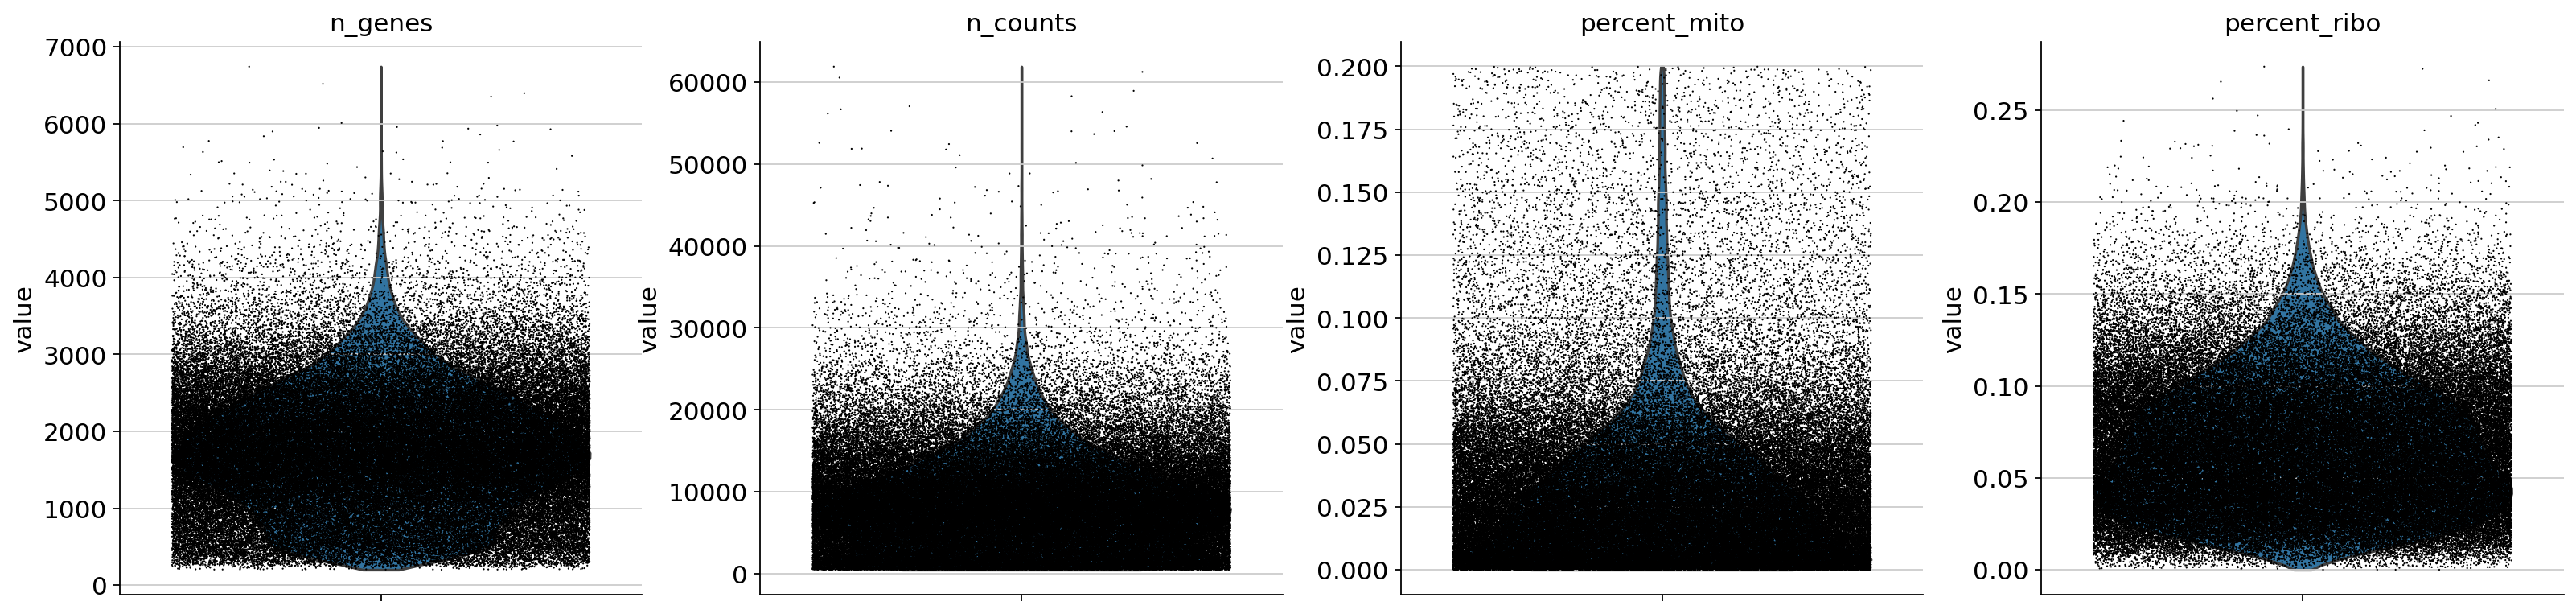

In [6]:
sc.settings.set_figure_params(dpi=80, facecolor='white')
sc.pl.violin(APC, ['n_genes', 'n_counts', 'percent_mito','percent_ribo'],
             jitter=0.4, multi_panel=True)

In [8]:
#APC_backup_raw = APC.copy()
sc.pp.normalize_per_cell(APC, counts_per_cell_after = 1e4)
sc.pp.log1p(APC)
APC.raw = APC

normalizing by total count per cell


Trying to set attribute `.obs` of view, copying.


    finished (0:00:04): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


extracting highly variable genes
    finished (0:00:04)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


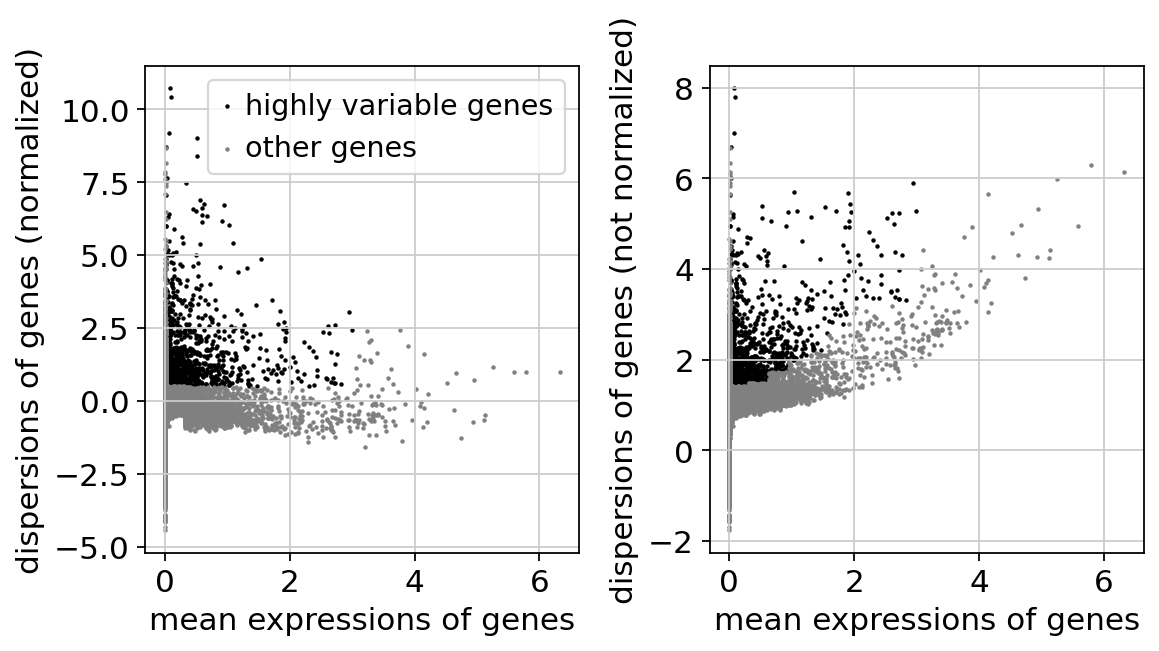

In [9]:
sc.pp.highly_variable_genes(APC, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(APC)

In [10]:
APC_filtered = APC[:, APC.var['highly_variable']]

In [11]:
sc.pp.regress_out(APC_filtered, ['percent_mito', 'percent_ribo']) ### slow

regressing out ['percent_mito', 'percent_ribo']
    sparse input is densified and may lead to high memory use
    finished (0:17:37)


In [12]:
sc.pp.scale(APC_filtered, max_value=10)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:40)


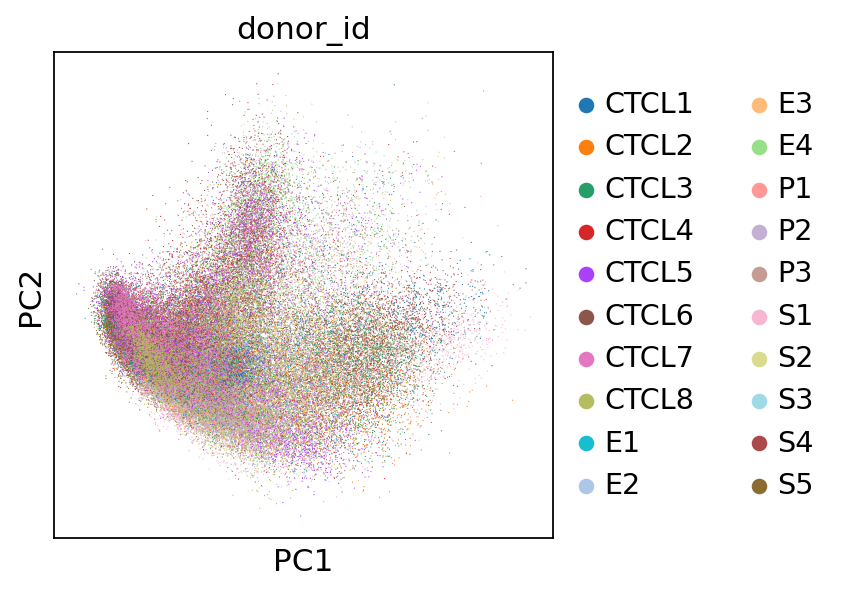

In [13]:
sc.tl.pca(APC_filtered, svd_solver='arpack', random_state=1234)
sc.pl.pca(APC_filtered, color = ['donor_id'])

In [14]:
adata_filtered_harmony = APC_filtered.copy()

In [15]:
#Set harmony variables
pca = np.array(adata_filtered_harmony.obsm["X_pca"])
batch = adata_filtered_harmony.obs['donor_id']
meta_data = adata_filtered_harmony.obs

#Run Harmony
ho = hm.run_harmony(pca, meta_data, ['donor_id'], theta = 3, random_state = 1234)
res = (pd.DataFrame(ho.Z_corr)).T
res.columns = ['X{}'.format(i + 1) for i in range(res.shape[1])]

#Insert coordinates back into object
adata_filtered_harmony.obsm["X_pca_back"]= adata_filtered_harmony.obsm["X_pca"][:]
adata_filtered_harmony.obsm["X_pca"] = np.array(res)

2021-11-09 14:49:50,357 - harmonypy - INFO - Iteration 1 of 10
2021-11-09 14:53:56,109 - harmonypy - INFO - Iteration 2 of 10
2021-11-09 14:57:55,822 - harmonypy - INFO - Iteration 3 of 10
2021-11-09 15:01:57,802 - harmonypy - INFO - Iteration 4 of 10
2021-11-09 15:06:00,516 - harmonypy - INFO - Iteration 5 of 10
2021-11-09 15:08:52,219 - harmonypy - INFO - Iteration 6 of 10
2021-11-09 15:11:32,511 - harmonypy - INFO - Iteration 7 of 10
2021-11-09 15:13:29,617 - harmonypy - INFO - Iteration 8 of 10
2021-11-09 15:15:17,617 - harmonypy - INFO - Iteration 9 of 10
2021-11-09 15:17:05,915 - harmonypy - INFO - Iteration 10 of 10
2021-11-09 15:18:44,818 - harmonypy - INFO - Stopped before convergence


In [16]:
sc.pp.neighbors(adata_filtered_harmony, n_neighbors=15, n_pcs=50, random_state = 1234)
sc.tl.umap(adata_filtered_harmony)

computing neighbors
    using 'X_pca' with n_pcs = 50


/home/jovyan/my-conda-envs/myenv_old/lib/python3.7/site-packages/numba/core/typed_passes.py:327: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../my-conda-envs/myenv_old/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/jovyan/my-conda-envs/myenv_old/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../my-c

    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:41)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:02:04)


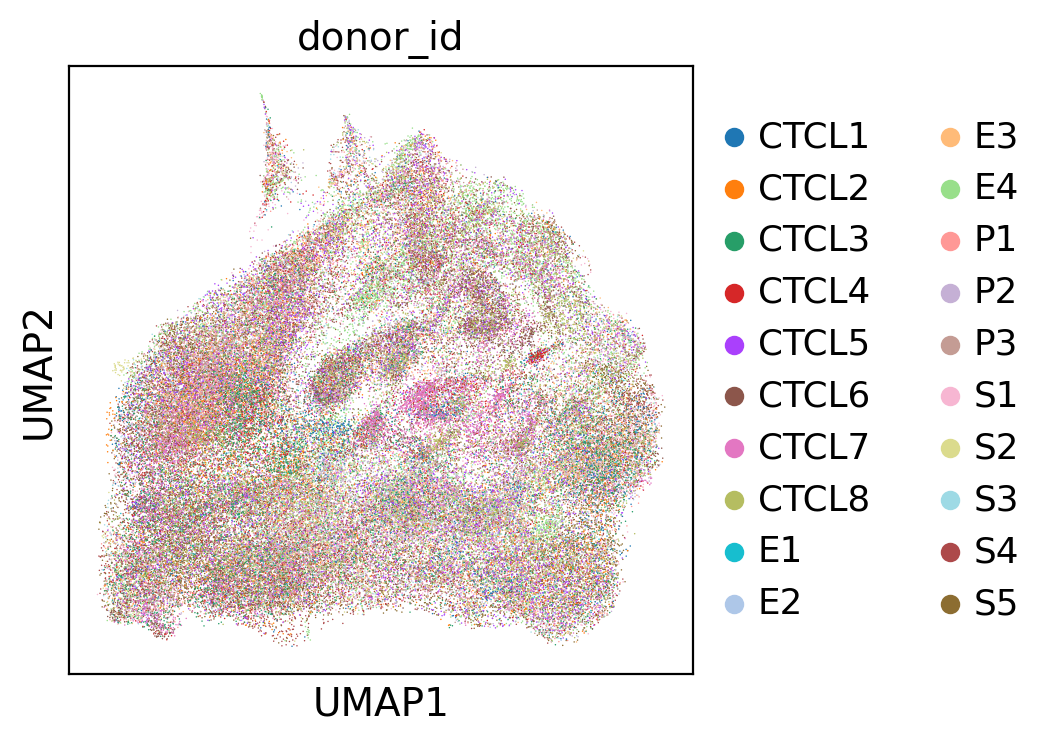

In [3]:
sc.settings.set_figure_params(dpi=100, facecolor='white')
sc.pl.umap(adata_filtered_harmony, color=['donor_id'])

In [4]:
sc.tl.leiden(adata_filtered_harmony, resolution=2.6, key_added='leiden_2.6')

running Leiden clustering
    finished: found 44 clusters and added
    'leiden_2.6', the cluster labels (adata.obs, categorical) (0:01:16)


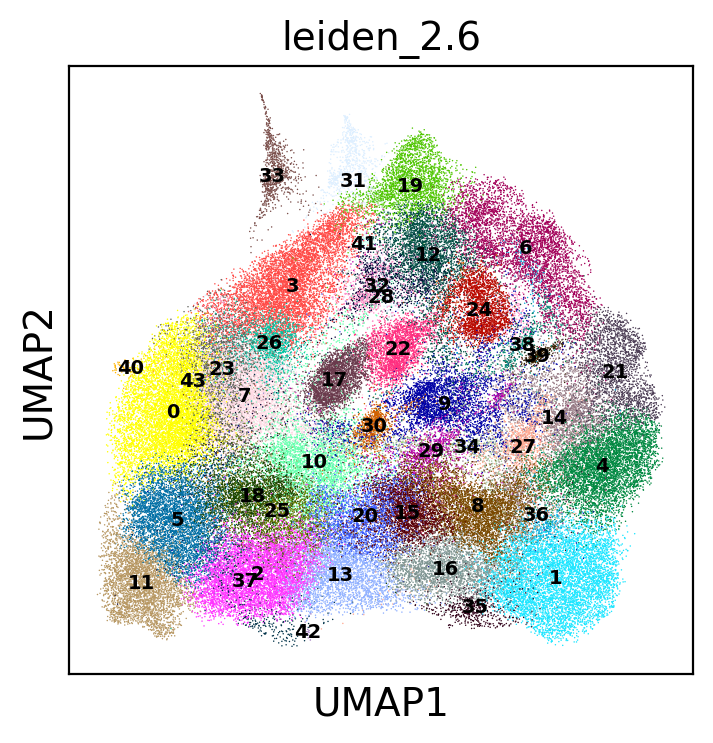

In [5]:
sc.settings.set_figure_params(dpi=100, facecolor='white')
sc.pl.umap(adata_filtered_harmony, color=['leiden_2.6'],legend_loc='on data', legend_fontsize=7)

In [456]:
adata_filtered_harmony.obs['annotation_r2.6'] = adata_filtered_harmony.obs['leiden_2.6']

In [7]:
adata_filtered_harmony[adata_filtered_harmony.obs['leiden_2.6']=='0'].obs.LR_pre_pre.value_counts()
adata_filtered_harmony.obs.loc[adata_filtered_harmony.obs['leiden_2.6']=='0', 'annotation_r2.6'] = "LC_4"

LC_4        4964
LC_3        1077
MigDC        415
moDC_3       388
Macro_1      205
moDC_2       160
moDC_1        72
Inf_mac       59
LC_2          35
Macro_2       21
Mono_mac      11
LC_1           9
DC2            5
DC1            4
Name: LR_pre_pre, dtype: int64

In [9]:
adata_filtered_harmony_sub = adata_filtered_harmony[~adata_filtered_harmony.obs['annotation_r2.6'].isin(['DB'])]

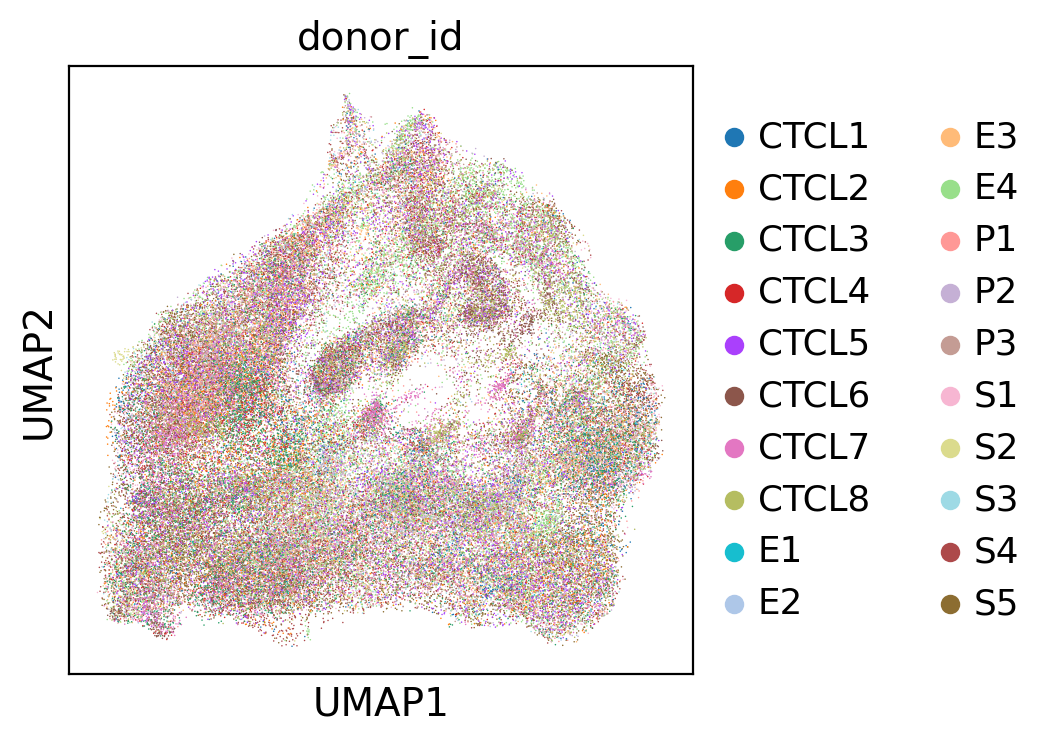

In [10]:
#col = ['#F35B92','#3E8D0E','#BAB1A7','#60528F',
# '#75CFC1','#BFD03F','#7982E3','#C2501E','#EC6CDD',
# '#BFA829','#794FE0','#A1208F']
sc.settings.set_figure_params(dpi=100, facecolor='white')
sc.pl.umap(adata_filtered_harmony_sub, color=['donor_id'])

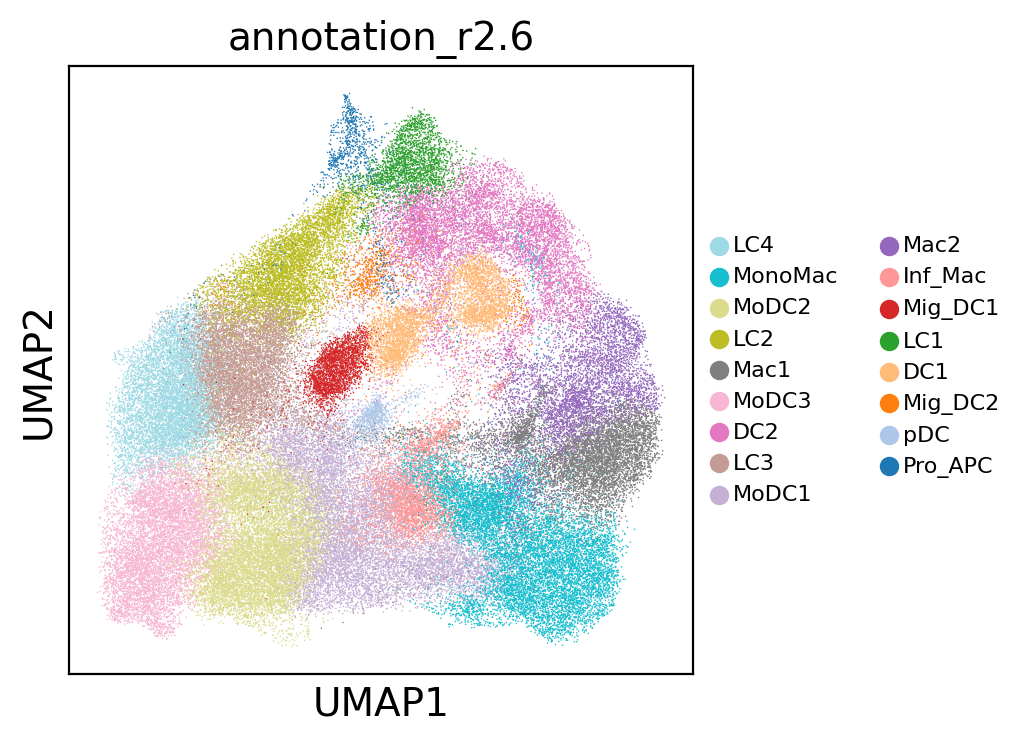

In [12]:
sc.settings.set_figure_params(dpi=100)
sc.pl.umap(adata_filtered_harmony_sub, color=['annotation_r2.6'], legend_fontsize=8, palette='tab20_r')

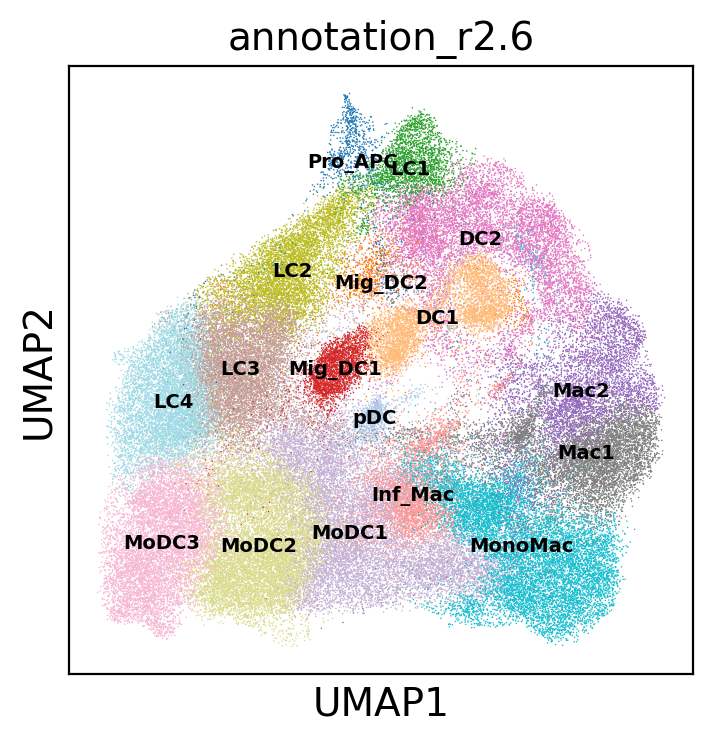

In [13]:
sc.settings.set_figure_params(dpi=100)
sc.pl.umap(adata_filtered_harmony_sub, color=['annotation_r2.6'], legend_loc='on data', legend_fontsize=7, palette='tab20_r')

In [12]:
genes = ['CD68', 'C1QB', 'C1QC', 
                       'CD163', 'MARCO', 'FCGR2A', 'CTSB', 'F13A1', 'NR4A1',
                       'NR4A2', 'KLF4', 'IL23A', 'CLEC9A','XCR1', 'CADM1', 
                       'CLEC10A','CD1C', 'CD207', 'CD1A', 'LAMP3','CCR7', 'CD40', 
                       'CD274', 'IDO1', 'CD200', 'PDCD1LG2', 'SOCS1', 'CD80', 
                       'MKI67', 'TOP2A', 'JCHAIN', 'IGKC']

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_annotation_r2.6']`


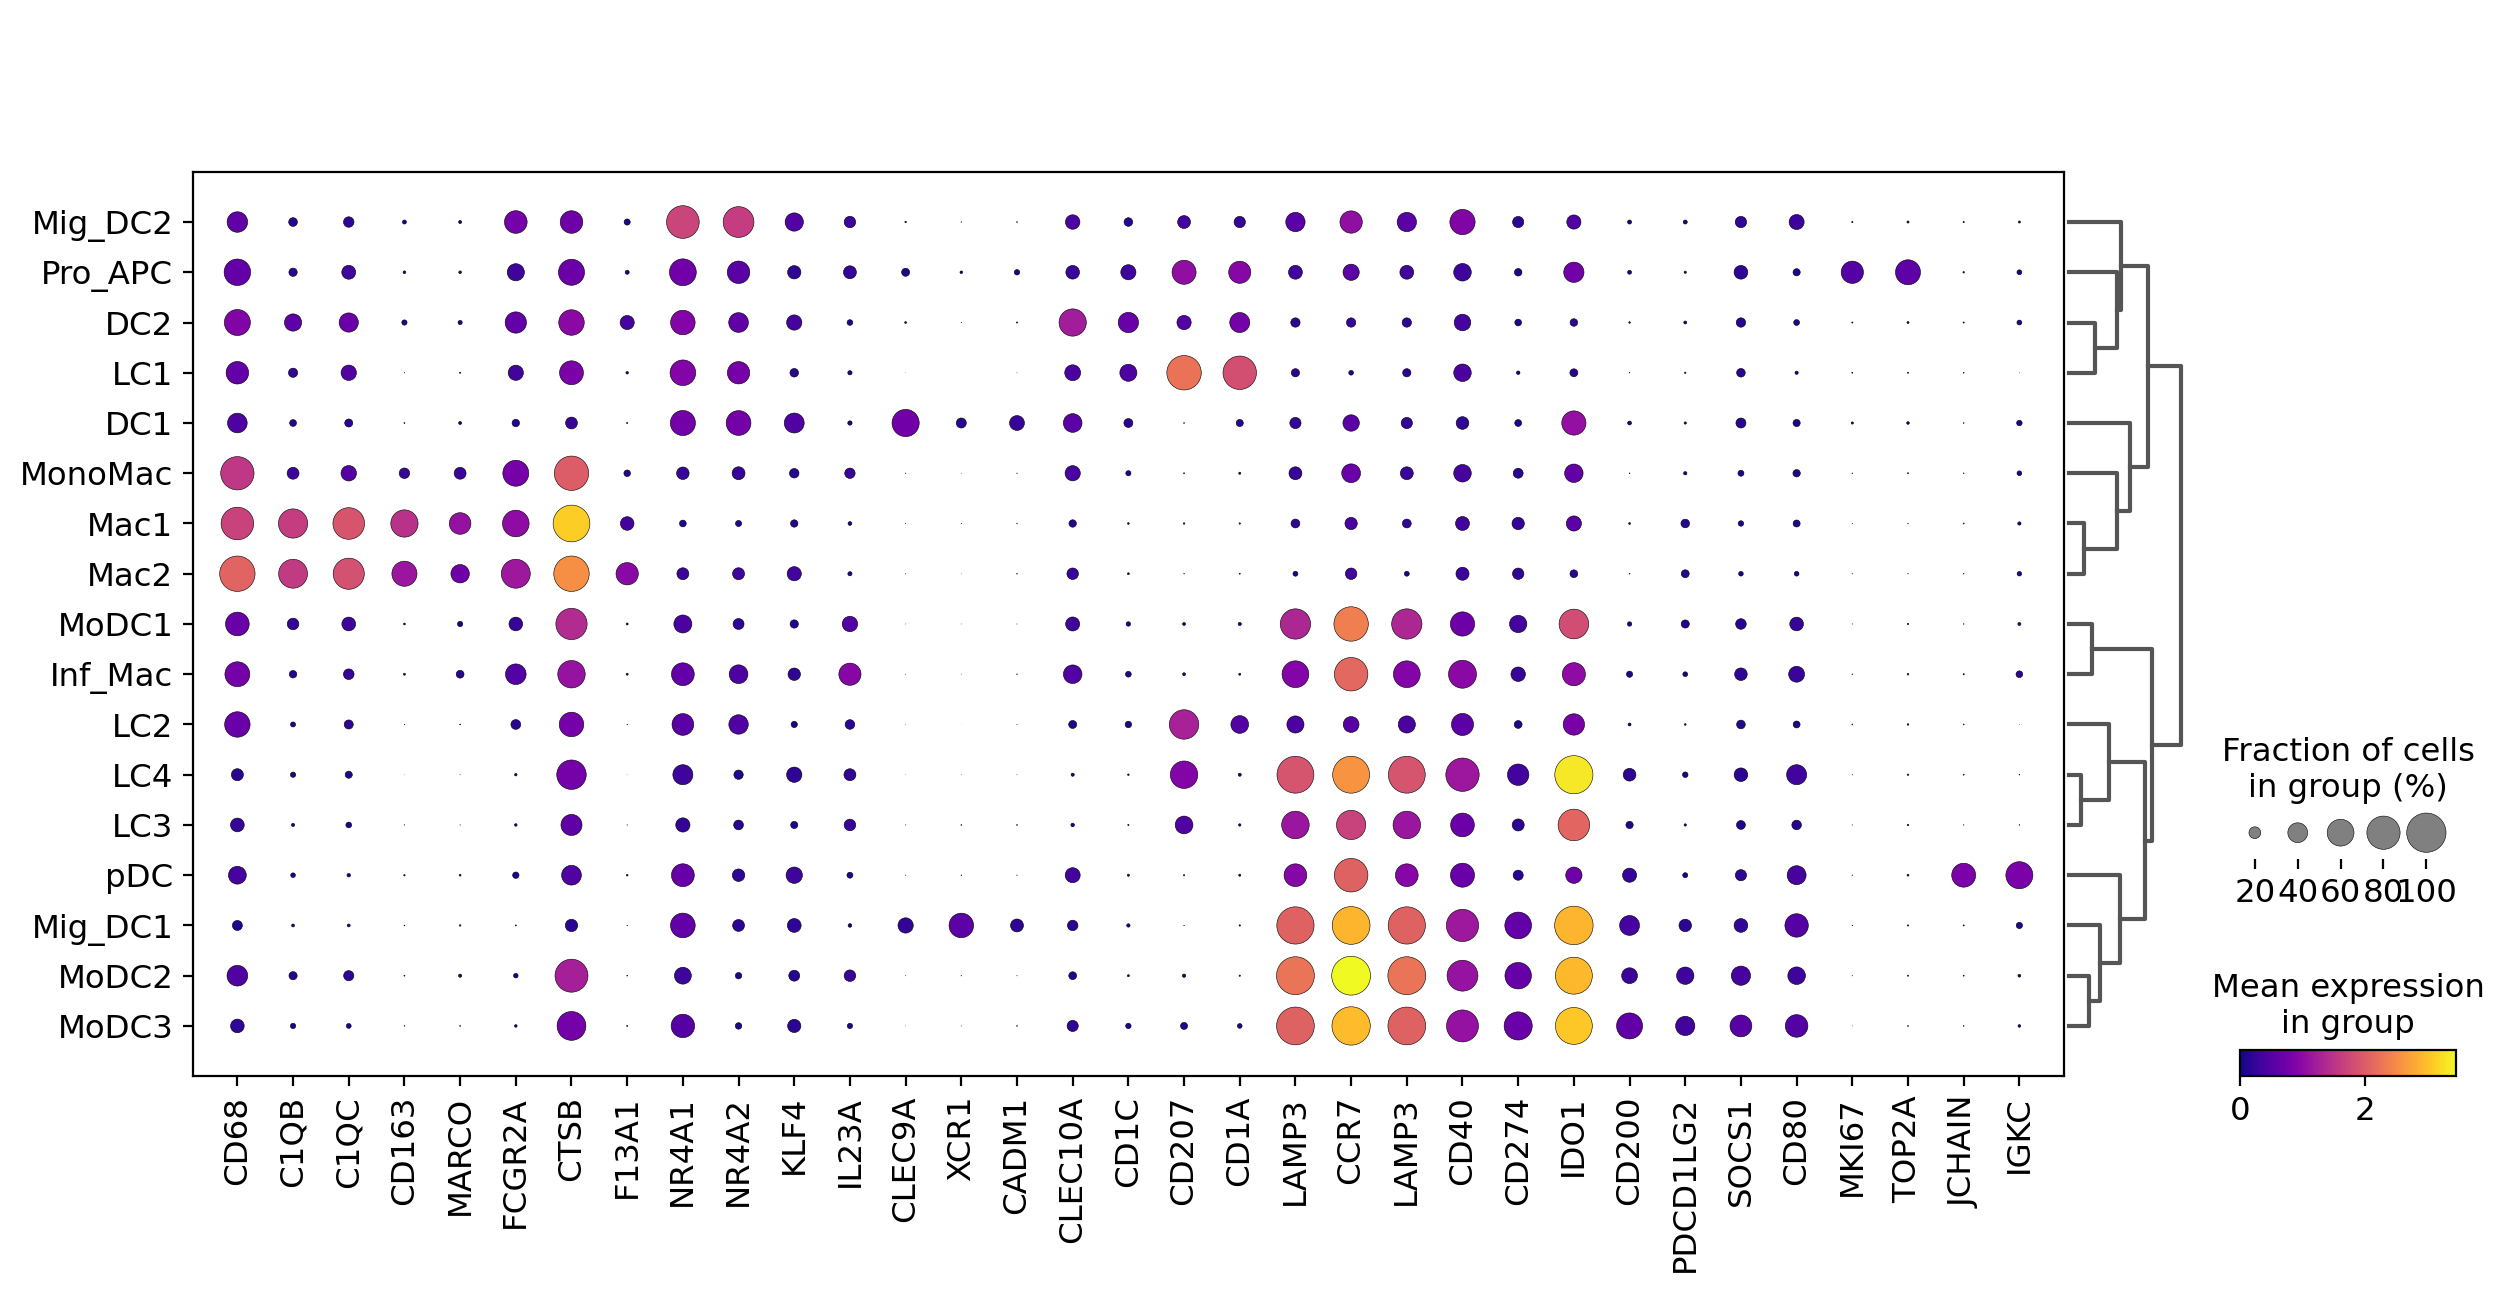

In [13]:
sc.settings.set_figure_params(dpi=100)
sc.tl.dendrogram(adata_filtered_harmony_sub, groupby='annotation_r2.6')
dp = sc.pl.dotplot(adata_filtered_harmony_sub, genes, groupby='annotation_r2.6', 
                   use_raw=True, dendrogram=True, color_map='plasma', save='.pdf')

#### condition based DEGs

In [6]:
adata_filtered_harmony_sub.obs['Site'][pd.isna(adata_filtered_harmony_sub.obs['Site'])] = 'lesion'

In [7]:
Site_condition = [i + '_' +j for i, j in zip(list(adata_filtered_harmony_sub.obs['integrated_sample_id']), list(adata_filtered_harmony_sub.obs['Site']))]
adata_filtered_harmony_sub.obs['Site_condition'] = Site_condition

In [8]:
adata_filtered_harmony_sub.obs.Site_condition.value_counts()

Healthy_non_lesion      38805
CTCL_lesion             33263
AD_lesion               11327
Psoriasis_lesion         6840
Psoriasis_non_lesion     6125
AD_non_lesion            5168
Name: Site_condition, dtype: int64

In [9]:
adata_filtered_harmony_sub_1 = adata_filtered_harmony_sub[adata_filtered_harmony_sub.obs['Site_condition'].isin(['Healthy_non_lesion', 
                                                                                                       'CTCL_lesion','AD_lesion','Psoriasis_lesion'])]

In [11]:
DC = adata_filtered_harmony_sub_1[adata_filtered_harmony_sub_1.obs['annotation_r2.6'].isin(['MoDC1', 'MoDC2', 'MoDC3',
                                                                                             'DC1','DC2','Mig_DC1','Mig_DC2'])]

/home/jovyan/my-conda-envs/myenv_old/lib/python3.7/site-packages/anndata/_core/anndata.py:1229: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'Site_condition' as categorical


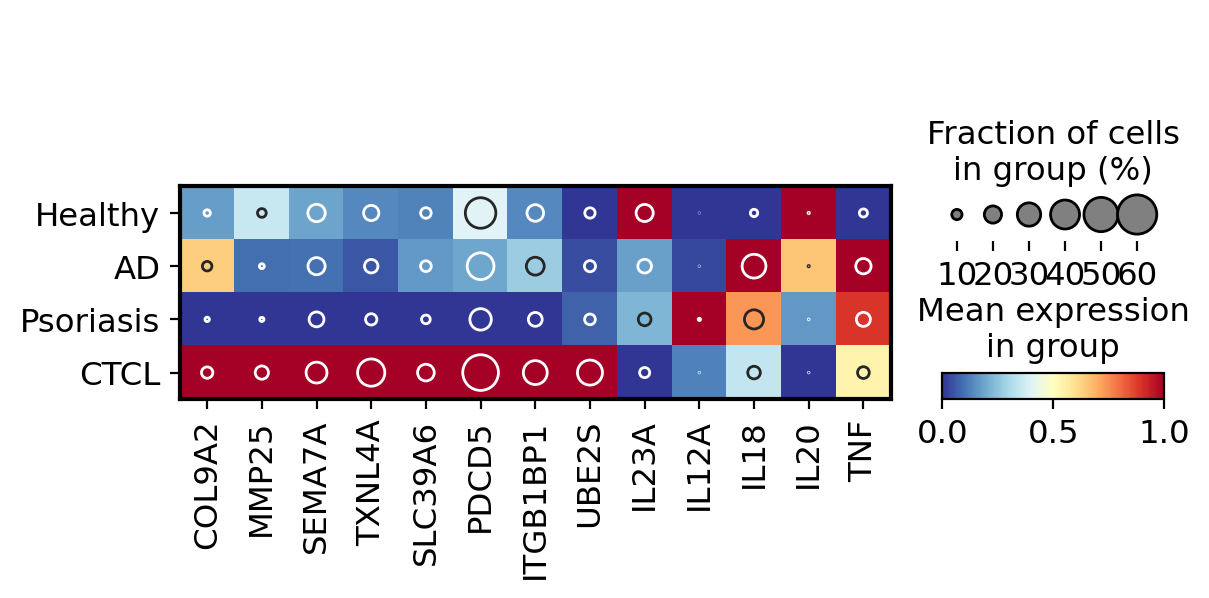

In [12]:
sc.settings.set_figure_params(dpi=100)
genes = ['COL9A2','MMP25','SEMA7A','TXNL4A','SLC39A6','PDCD5','ITGB1BP1','UBE2S',
        'IL23A','IL12A','IL18','IL20','TNF']
dp = sc.pl.dotplot(DC, var_names=genes, groupby='integrated_sample_id',dendrogram=False,
                   standard_scale='var',use_raw=True,var_group_rotation=0,swap_axes=False,return_fig=True)
dp.style(cmap='RdYlBu_r',color_on='square',dot_edge_color=None,dot_edge_lw=1)
dp.savefig('/home/jovyan/farm/CTCL/script_notebook/figures/DEGs_DC.pdf')

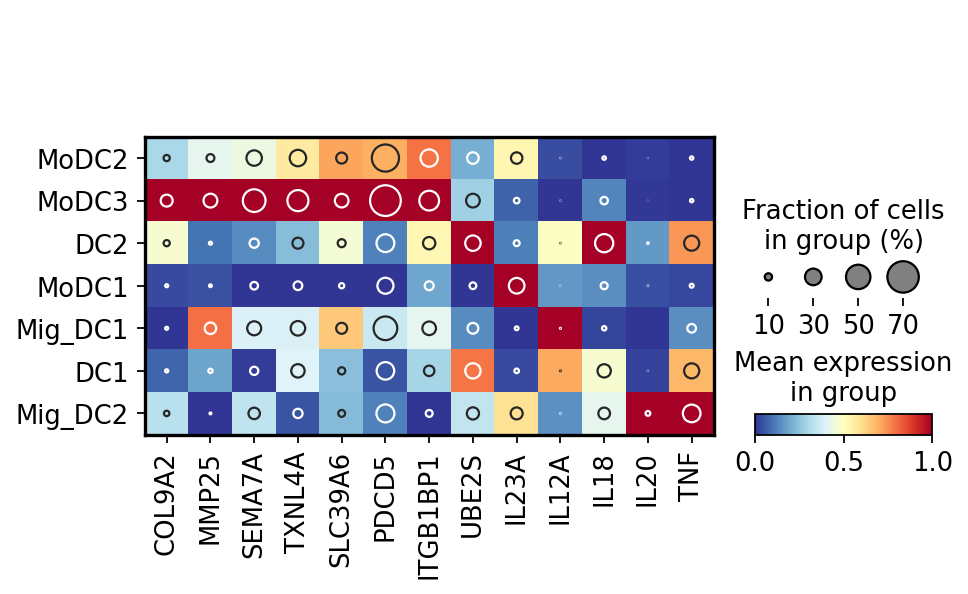

In [12]:
#genes = ['PVR','COL6A3','COL9A2','MMP25']
dp = sc.pl.dotplot(DC, var_names=genes, groupby='annotation_r2.6',dendrogram=False,
                   standard_scale='var',use_raw=True,var_group_rotation=0,swap_axes=False,return_fig=True)
dp.style(cmap='RdYlBu_r',color_on='square',dot_edge_color=None,dot_edge_lw=1)
dp.savefig('/home/jovyan/farm/CTCL/script_notebook/figures/DEGs_DC_subsets.pdf')

In [13]:
Mac = adata_filtered_harmony_sub_1[adata_filtered_harmony_sub_1.obs['annotation_r2.6'].isin(['MonoMac','Mac1','Mac2',
                                                                                              'Inf_Mac'])]

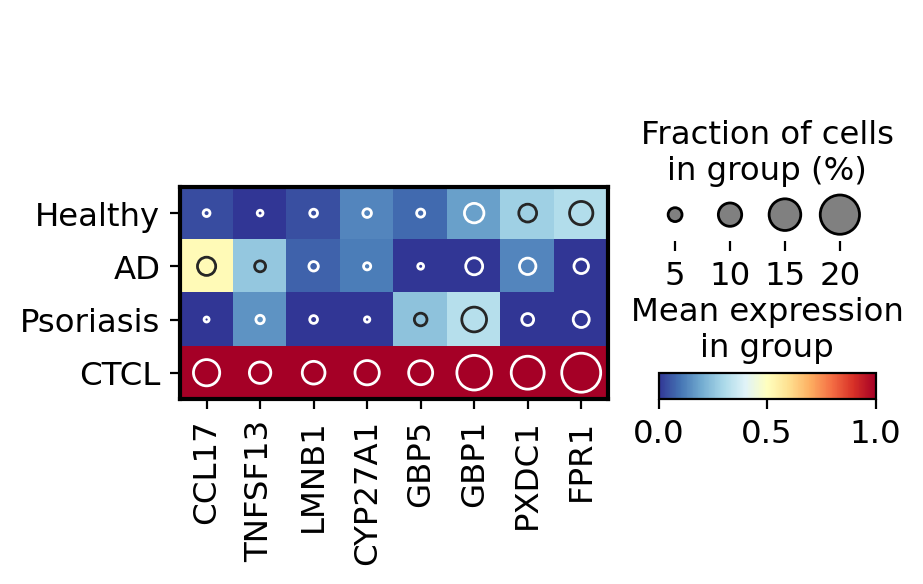

In [20]:
genes = ['CCL17','TNFSF13','LMNB1','CYP27A1','GBP5','GBP1','PXDC1','FPR1']
dp = sc.pl.dotplot(Mac, var_names=genes, groupby='integrated_sample_id',dendrogram=False,
                   standard_scale='var',use_raw=True,var_group_rotation=0,swap_axes=False,return_fig=True)
dp.style(cmap='RdYlBu_r',color_on='square',dot_edge_color=None,dot_edge_lw=1)
dp.savefig('/home/jovyan/farm/CTCL/script_notebook/figures/DEGs_Macro.pdf')

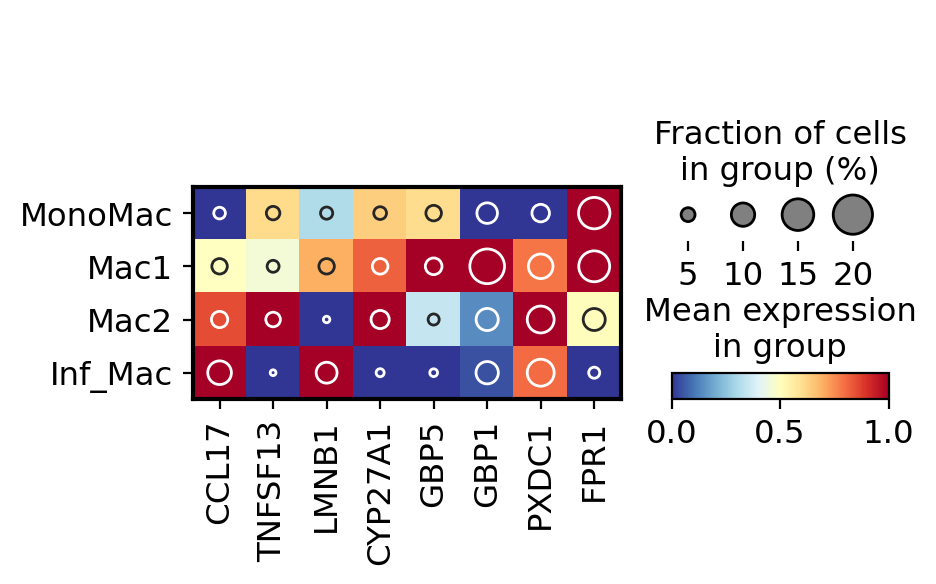

In [21]:
#genes = ['PVR','COL6A3','COL9A2','MMP25']
dp = sc.pl.dotplot(Mac, var_names=genes, groupby='annotation_r2.6',dendrogram=False,
                   standard_scale='var',use_raw=True,var_group_rotation=0,swap_axes=False,return_fig=True)
dp.style(cmap='RdYlBu_r',color_on='square',dot_edge_color=None,dot_edge_lw=1)
dp.savefig('/home/jovyan/farm/CTCL/script_notebook/figures/DEGs_Macro_anno.pdf')

In [22]:
LC = adata_filtered_harmony_sub_1[adata_filtered_harmony_sub_1.obs['annotation_r2.6'].isin(['LC1', 'LC2', 
                                                                                             'LC3','LC4'])]

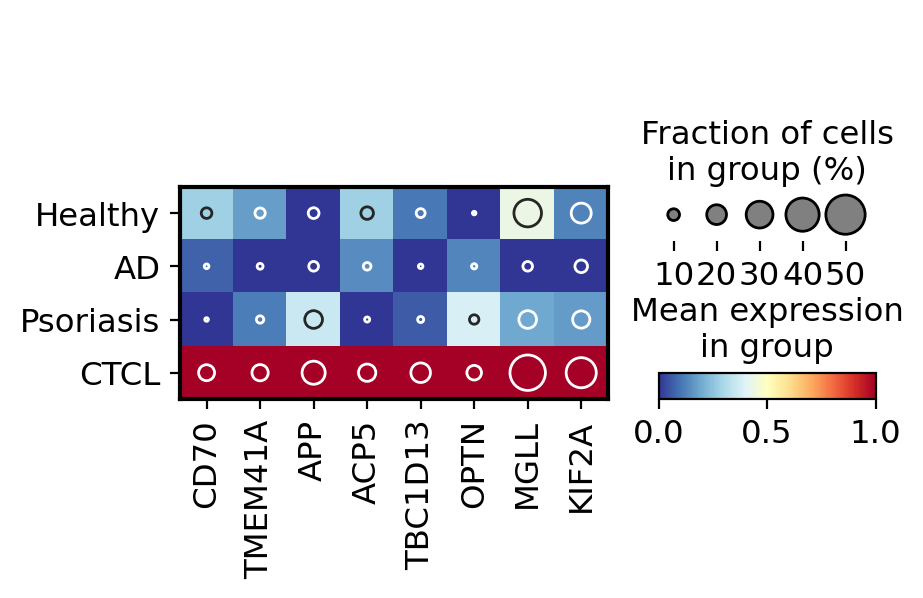

In [39]:
genes = ['CD70','TMEM41A','APP','ACP5','TBC1D13','OPTN','MGLL','KIF2A']
dp = sc.pl.dotplot(LC, var_names=genes, groupby='integrated_sample_id',dendrogram=False,
                   standard_scale='var',use_raw=True,var_group_rotation=0,swap_axes=False,return_fig=True)
dp.style(cmap='RdYlBu_r',color_on='square',dot_edge_color=None,dot_edge_lw=1)
dp.savefig('/home/jovyan/farm/CTCL/script_notebook/figures/DEGs_LC.pdf')

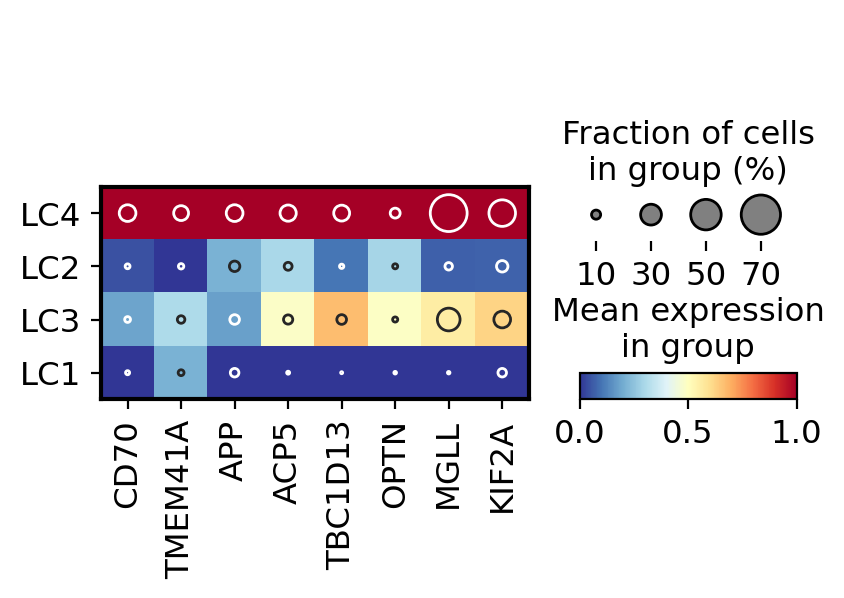

In [40]:
dp = sc.pl.dotplot(LC, var_names=genes, groupby='annotation_r2.6',dendrogram=False,
                   standard_scale='var',use_raw=True,var_group_rotation=0,swap_axes=False,return_fig=True)
dp.style(cmap='RdYlBu_r',color_on='square',dot_edge_color=None,dot_edge_lw=1)
dp.savefig('/home/jovyan/farm/CTCL/script_notebook/figures/DEGs_LC_anno.pdf')